In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore') # Suppress warnings

In [ ]:
# Data loading and preprocessing
df = pd.read_csv('../data/delays.csv')
df.dropna(inplace=True)
df = df[df['arr_flights'] > 0]
df['delay_rate'] = df['arr_del15'] / df['arr_flights']
df['high_delay'] = (df['delay_rate'] > 0.25).astype(int)

# Extract time-based features
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-01') # Assuming day 1 for simplicity
df['day_of_week'] = df['date'].dt.dayofweek # Monday=0, Sunday=6
df['quarter'] = df['date'].dt.quarter

# Label encoding for categorical features
le_carrier = LabelEncoder()
le_airport = LabelEncoder()
df['carrier_enc'] = le_carrier.fit_transform(df['carrier'])
df['airport_enc'] = le_airport.fit_transform(df['airport'])

In [ ]:
# Define features and target
features = [
    'year', 'month', 'day_of_week', 'quarter',
    'carrier_enc', 'airport_enc',
    'arr_cancelled', 'arr_diverted',
    'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
]
target = 'high_delay'

X = df[features]
y = df[target]

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # Stratify to maintain class balance
)

print(f"Total samples: {len(df)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Target distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"Target distribution in test set:\n{y_test.value_counts(normalize=True)}")

# Scale numerical features (important for MLP, less critical for tree-based models but good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for consistent feature naming
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)


Total samples: 171223
Training samples: 136978
Test samples: 34245
Target distribution in training set:
high_delay
0    0.778855
1    0.221145
Name: proportion, dtype: float64
Target distribution in test set:
high_delay
0    0.778858
1    0.221142
Name: proportion, dtype: float64


In [ ]:
# Function to evaluate and plot model results
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n--- {model_name} Evaluation ---")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"True Negatives: {cm[0,0]}")
    print(f"False Positives: {cm[0,1]}")
    print(f"False Negatives: {cm[1,0]}")
    print(f"True Positives: {cm[1,1]}")

    plt.figure(figsize=(15, 6))

    # Plot Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{model_name} Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # Precision-recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    plt.figure(figsize=(7, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'{model_name} Precision-Recall Curve', fontsize=16)
    plt.legend(loc="lower left")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Average Precision Score: {avg_precision:.4f}")
    return roc_auc, avg_precision



--- Training Random Forest Classifier ---
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best Random Forest parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20, 'class_weight': 'balanced'}

--- Random Forest Evaluation ---
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     26672
           1       0.62      0.59      0.61      7573

    accuracy                           0.83     34245
   macro avg       0.75      0.75      0.75     34245
weighted avg       0.83      0.83      0.83     34245

True Negatives: 23895
False Positives: 2777
False Negatives: 3070
True Positives: 4503


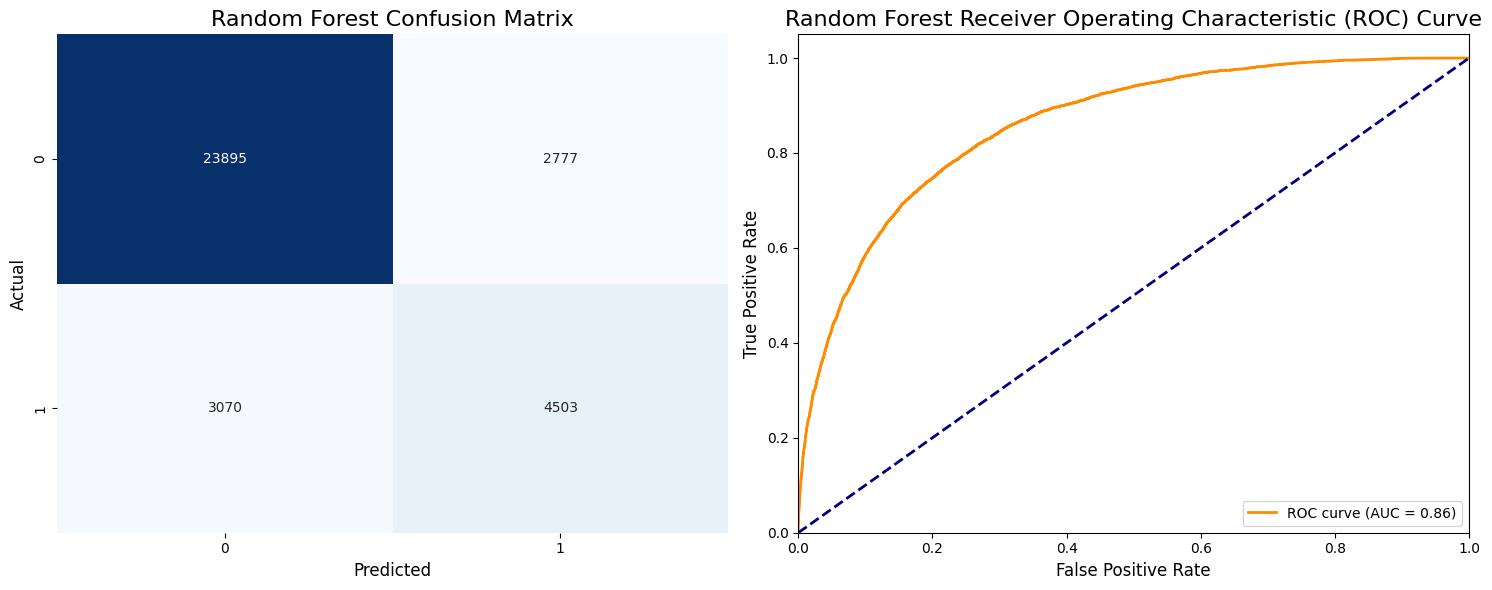

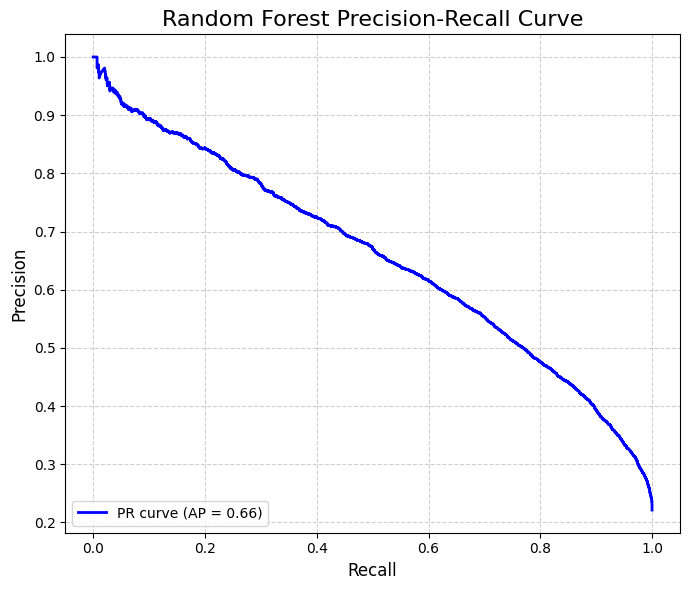

ROC AUC Score: 0.8590
Average Precision Score: 0.6568

Random Forest Feature Importances:
late_aircraft_ct: 0.1507
nas_ct: 0.1243
carrier_enc: 0.1231
carrier_ct: 0.1191
year: 0.0915
month: 0.0904
airport_enc: 0.0844
weather_ct: 0.0646
arr_cancelled: 0.0520
day_of_week: 0.0421
arr_diverted: 0.0211
quarter: 0.0192
security_ct: 0.0176


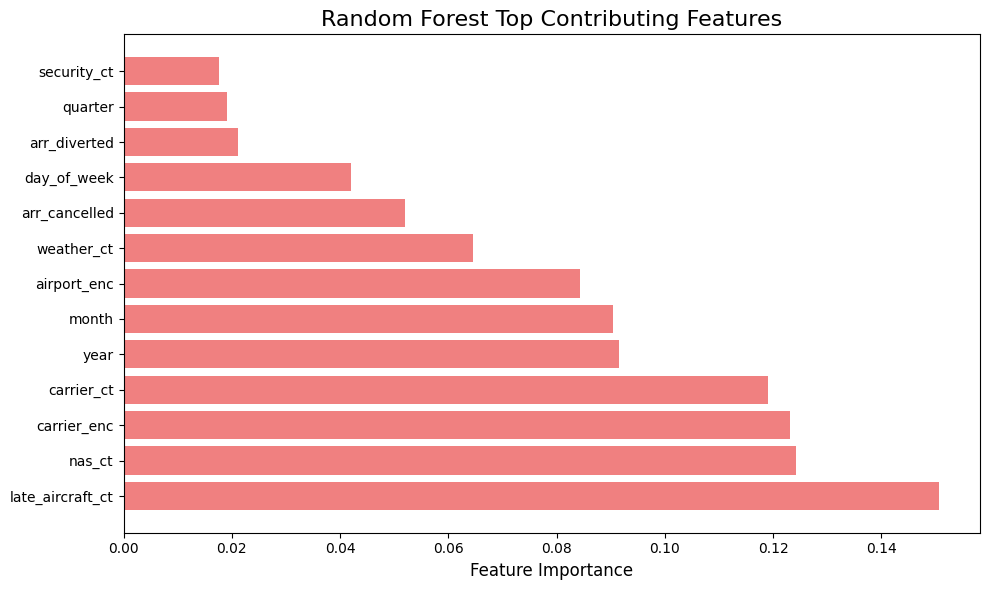

In [ ]:
# Random Forest Classifier
print("\n--- Training Random Forest Classifier ---")
rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning for Random Forest (RandomizedSearchCV for efficiency)
param_dist_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced'] # Handle class imbalance
}
random_search_rf = RandomizedSearchCV(
    rf_model, param_distributions=param_dist_rf, n_iter=3, cv=2,
    scoring='roc_auc', random_state=42, n_jobs=-1, verbose=1
)
random_search_rf.fit(X_train, y_train)
best_rf_model = random_search_rf.best_estimator_
print(f"Best Random Forest parameters: {random_search_rf.best_params_}")
rf_auc, rf_ap = evaluate_model(best_rf_model, X_test, y_test, "Random Forest")

# Feature importance for Random Forest
importances_rf = best_rf_model.feature_importances_
sorted_features_rf = sorted(zip(features, importances_rf), key=lambda x: x[1], reverse=True)
print("\nRandom Forest Feature Importances:")
for f, score in sorted_features_rf:
    print(f"{f}: {score:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importances_rf[np.argsort(importances_rf)[::-1]], align='center', color='lightcoral')
plt.yticks(range(len(features)), [features[i] for i in np.argsort(importances_rf)[::-1]])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Random Forest Top Contributing Features', fontsize=16)
plt.tight_layout()
plt.show()



--- Training LightGBM Classifier ---
Fitting 2 folds for each of 3 candidates, totalling 6 fits
[LightGBM] [Info] Number of positive: 15146, number of negative: 53343
[LightGBM] [Info] Number of positive: 15146, number of negative: 53343
[LightGBM] [Info] Number of positive: 15146, number of negative: 53343
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Total Bins 1900
[LightGBM] [Info] Number of data points in the train set: 68489, number of used features: 13
[LightGBM] [Info] Number of data points in the train set: 68489, number of us

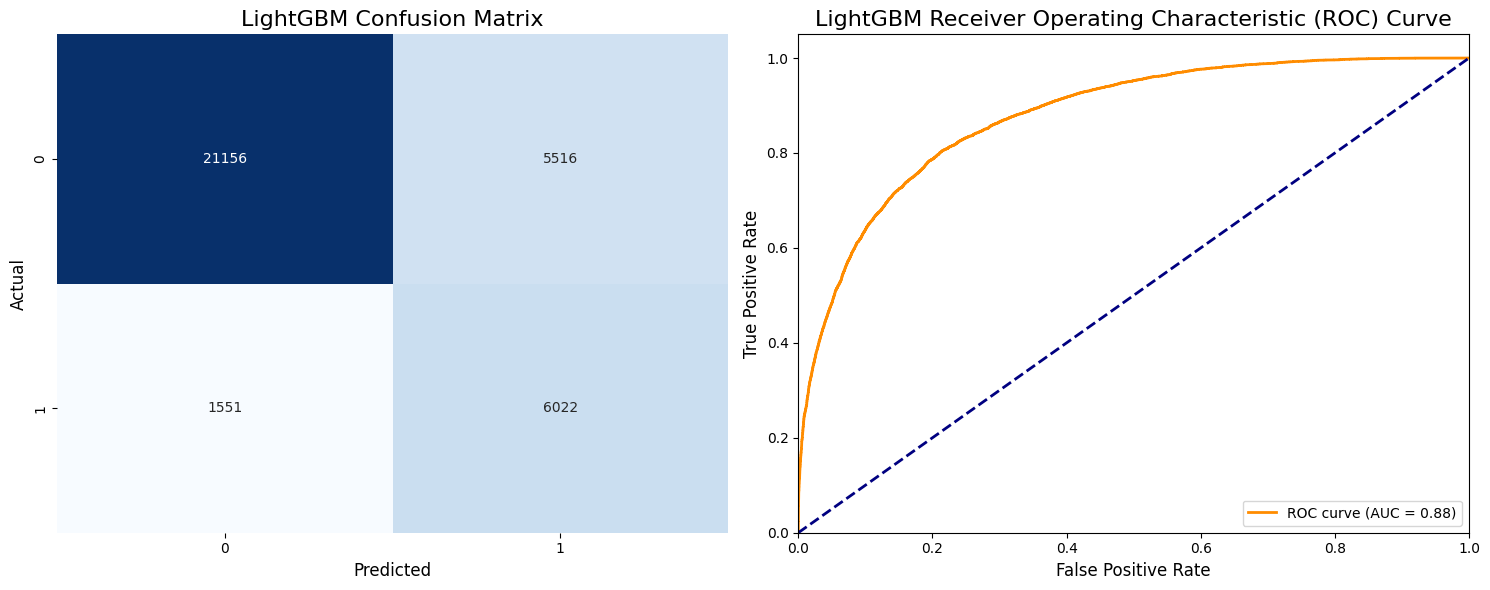

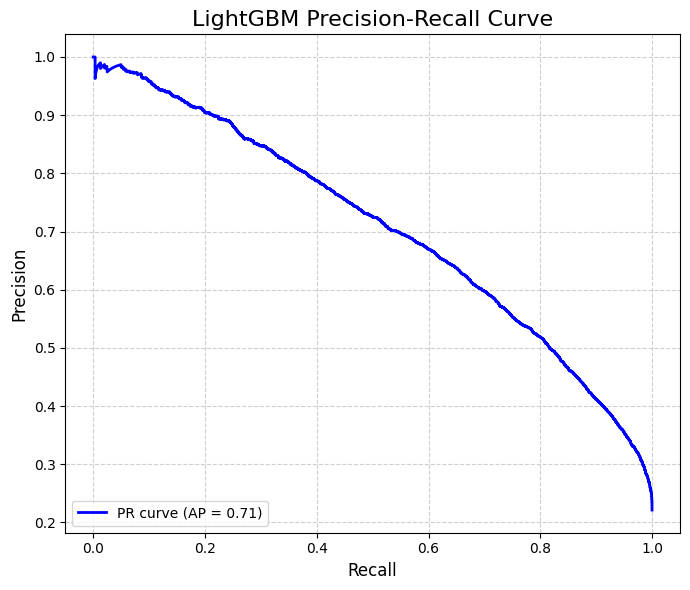

ROC AUC Score: 0.8774
Average Precision Score: 0.7062

LightGBM Feature Importances:
carrier_enc: 1516.0000
airport_enc: 1079.0000
year: 820.0000
carrier_ct: 801.0000
nas_ct: 790.0000
late_aircraft_ct: 767.0000
month: 678.0000
weather_ct: 414.0000
arr_cancelled: 394.0000
day_of_week: 291.0000
arr_diverted: 119.0000
security_ct: 117.0000
quarter: 14.0000


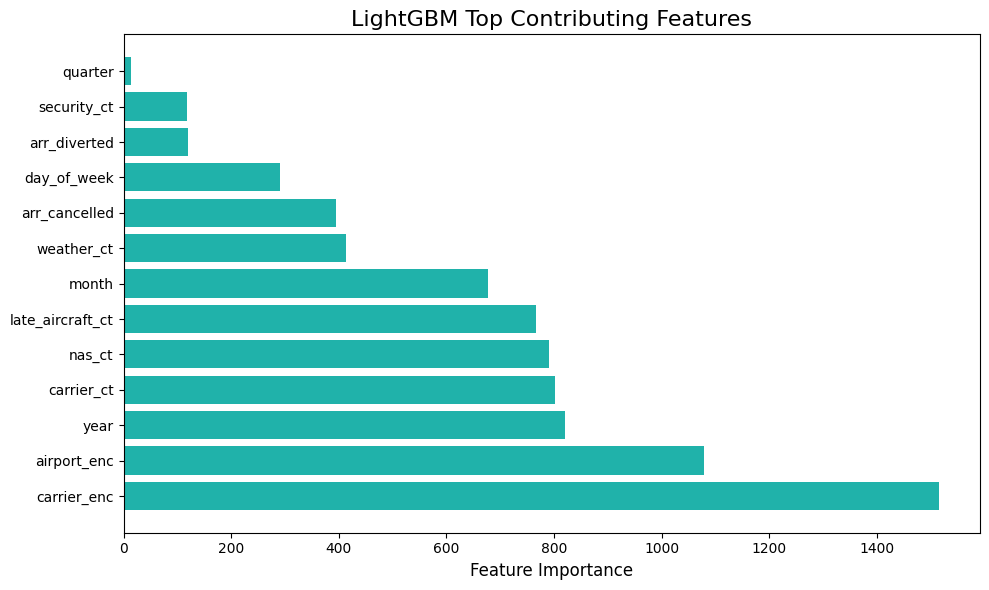

In [ ]:
# Gradient Boosting Classifier (LightGBM)
print("\n--- Training LightGBM Classifier ---")
lgb_model = lgb.LGBMClassifier(random_state=42, objective='binary')

# Hyperparameter tuning for LightGBM
param_grid_lgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 10, 20], # -1 means no limit
    'reg_alpha': [0, 0.1, 0.5], # L1 regularization
    'reg_lambda': [0, 0.1, 0.5], # L2 regularization
    'colsample_bytree': [0.7, 0.8, 0.9], # Subsample columns when building tree
    'subsample': [0.7, 0.8, 0.9], # Subsample rows when building tree
    'is_unbalance': [True, False] # Handle class imbalance
}
grid_search_lgb = RandomizedSearchCV(
    lgb_model, param_distributions=param_grid_lgb, n_iter=3, cv=2,
    scoring='roc_auc', random_state=42, n_jobs=-1, verbose=1
)
grid_search_lgb.fit(X_train, y_train)
best_lgb_model = grid_search_lgb.best_estimator_
print(f"Best LightGBM parameters: {grid_search_lgb.best_params_}")
lgb_auc, lgb_ap = evaluate_model(best_lgb_model, X_test, y_test, "LightGBM")

# Feature importance for LightGBM
importances_lgb = best_lgb_model.feature_importances_
sorted_features_lgb = sorted(zip(features, importances_lgb), key=lambda x: x[1], reverse=True)
print("\nLightGBM Feature Importances:")
for f, score in sorted_features_lgb:
    print(f"{f}: {score:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importances_lgb[np.argsort(importances_lgb)[::-1]], align='center', color='lightseagreen')
plt.yticks(range(len(features)), [features[i] for i in np.argsort(importances_lgb)[::-1]])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('LightGBM Top Contributing Features', fontsize=16)
plt.tight_layout()
plt.show()


--- Training XGBoost Classifier ---
Fitting 2 folds for each of 3 candidates, totalling 6 fits


/Users/ayan/Documents/Projects/Flight Delay Prediction/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:03:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ayan/Documents/Projects/Flight Delay Prediction/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:03:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ayan/Documents/Projects/Flight Delay Prediction/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:03:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ayan/Documents/Projects/Flight Delay Prediction/.venv/lib/python3.12/site-packages/xgboost/train

Best XGBoost parameters: {'subsample': 0.9, 'scale_pos_weight': 1, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'lambda': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7, 'alpha': 0}

--- XGBoost Evaluation ---
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     26672
           1       0.76      0.48      0.59      7573

    accuracy                           0.85     34245
   macro avg       0.81      0.72      0.75     34245
weighted avg       0.84      0.85      0.84     34245

True Negatives: 25521
False Positives: 1151
False Negatives: 3940
True Positives: 3633


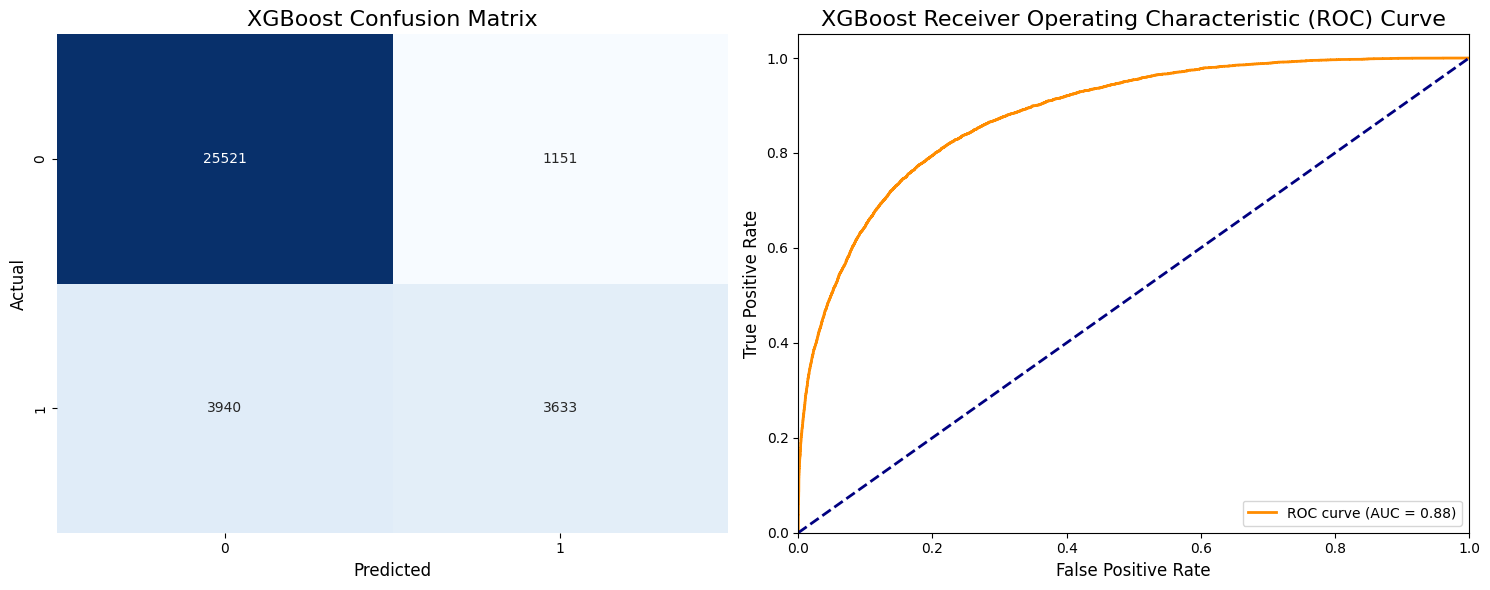

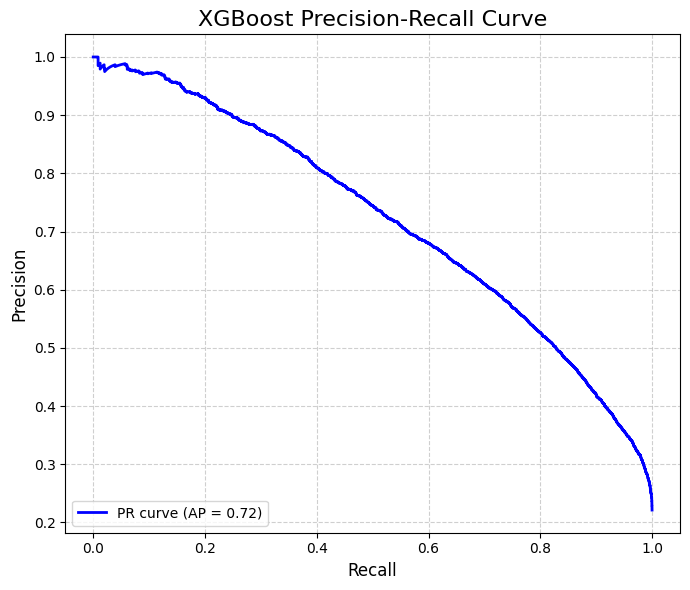

ROC AUC Score: 0.8822
Average Precision Score: 0.7212

XGBoost Feature Importances:
carrier_enc: 0.1580
month: 0.1560
year: 0.1370
late_aircraft_ct: 0.0940
nas_ct: 0.0821
carrier_ct: 0.0629
day_of_week: 0.0566
arr_diverted: 0.0521
arr_cancelled: 0.0475
airport_enc: 0.0444
quarter: 0.0415
weather_ct: 0.0369
security_ct: 0.0310


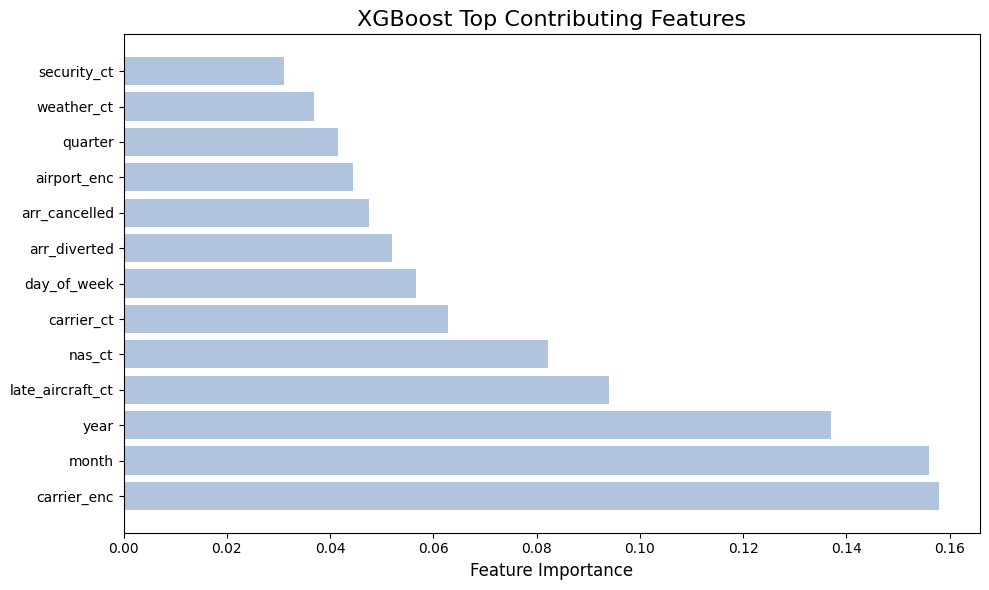

In [ ]:
# XGBoost Classifier
print("\n--- Training XGBoost Classifier ---")
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2], # Minimum loss reduction required to make a further partition on a leaf node of the tree
    'lambda': [0, 0.1, 0.5], # L2 regularization
    'alpha': [0, 0.1, 0.5], # L1 regularization
    'scale_pos_weight': [1, (y_train == 0).sum() / (y_train == 1).sum()] # Handle class imbalance
}
grid_search_xgb = RandomizedSearchCV(
    xgb_model, param_distributions=param_grid_xgb, n_iter=3, cv=2,
    scoring='roc_auc', random_state=42, n_jobs=-1, verbose=1
)
grid_search_xgb.fit(X_train, y_train)
best_xgb_model = grid_search_xgb.best_estimator_
print(f"Best XGBoost parameters: {grid_search_xgb.best_params_}")
xgb_auc, xgb_ap = evaluate_model(best_xgb_model, X_test, y_test, "XGBoost")

# Feature Importance for XGBoost
importances_xgb = best_xgb_model.feature_importances_
sorted_features_xgb = sorted(zip(features, importances_xgb), key=lambda x: x[1], reverse=True)
print("\nXGBoost Feature Importances:")
for f, score in sorted_features_xgb:
    print(f"{f}: {score:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importances_xgb[np.argsort(importances_xgb)[::-1]], align='center', color='lightsteelblue')
plt.yticks(range(len(features)), [features[i] for i in np.argsort(importances_xgb)[::-1]])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('XGBoost Top Contributing Features', fontsize=16)
plt.tight_layout()
plt.show()



--- Training MLP Classifier ---
Fitting 2 folds for each of 3 candidates, totalling 6 fits


/Users/ayan/Documents/Projects/Flight Delay Prediction/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ayan/Documents/Projects/Flight Delay Prediction/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ayan/Documents/Projects/Flight Delay Prediction/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best MLP parameters: {'solver': 'sgd', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'tanh'}

--- MLP Classifier Evaluation ---
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     26672
           1       0.68      0.47      0.55      7573

    accuracy                           0.83     34245
   macro avg       0.77      0.70      0.73     34245
weighted avg       0.82      0.83      0.82     34245

True Negatives: 25021
False Positives: 1651
False Negatives: 4044
True Positives: 3529


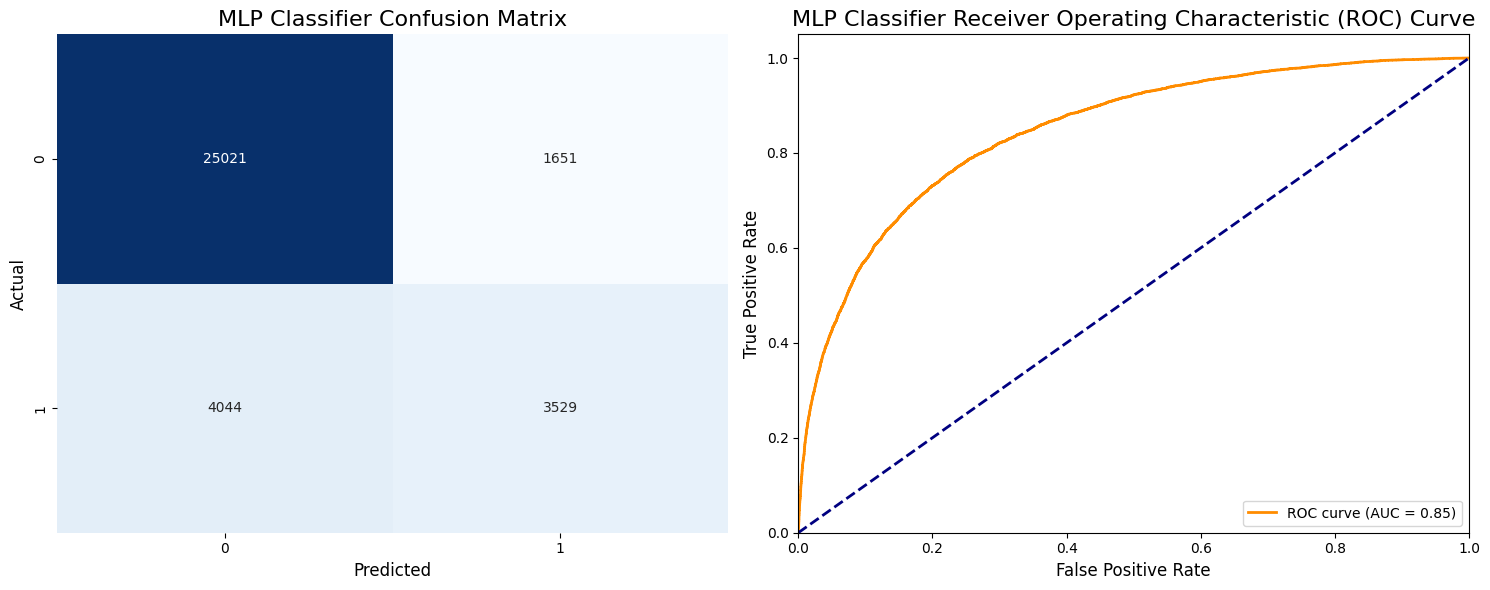

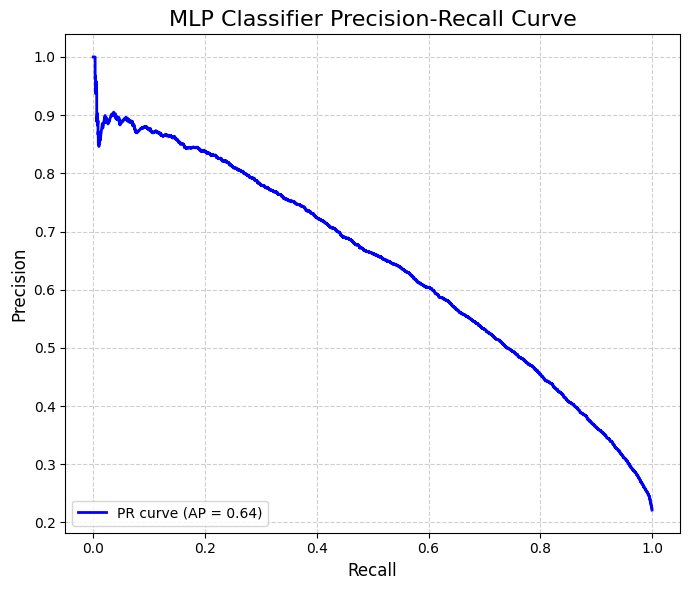

ROC AUC Score: 0.8456
Average Precision Score: 0.6418


In [ ]:
# Multi-layer Perceptron (Neural Network)
print("\n--- Training MLP Classifier ---")
mlp_model = MLPClassifier(random_state=42, max_iter=500)

# Hyperparameter tuning for MLP
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01], # L2 regularization
    'learning_rate_init': [0.001, 0.01, 0.05],
}
random_search_mlp = RandomizedSearchCV(
    mlp_model, param_distributions=param_grid_mlp, n_iter=3, cv=2,
    scoring='roc_auc', random_state=42, n_jobs=-1, verbose=1
)
random_search_mlp.fit(X_train_scaled_df, y_train) # Use scaled data for MLP
best_mlp_model = random_search_mlp.best_estimator_
print(f"Best MLP parameters: {random_search_mlp.best_params_}")
mlp_auc, mlp_ap = evaluate_model(best_mlp_model, X_test_scaled_df, y_test, "MLP Classifier")




--- Model Comparison ---

Model Comparison (Sorted by ROC AUC):
            Model   ROC AUC  Average Precision
2         XGBoost  0.882167           0.721168
1        LightGBM  0.877392           0.706241
0   Random Forest  0.858993           0.656815
3  MLP Classifier  0.845622           0.641842

Model Comparison (Sorted by Average Precision):
            Model   ROC AUC  Average Precision
2         XGBoost  0.882167           0.721168
1        LightGBM  0.877392           0.706241
0   Random Forest  0.858993           0.656815
3  MLP Classifier  0.845622           0.641842


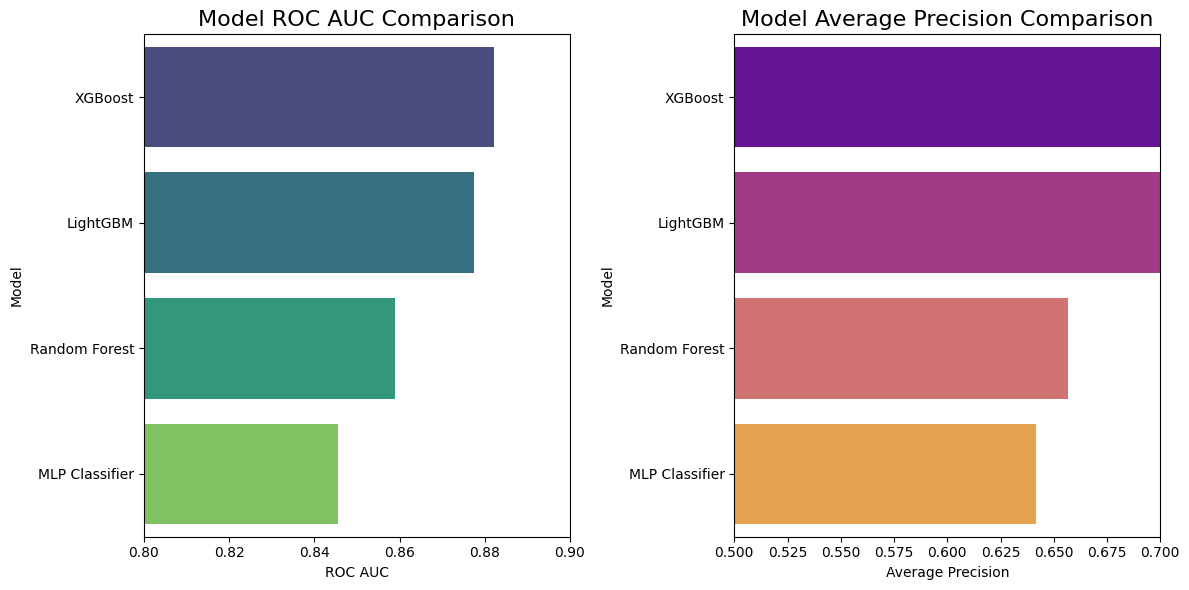

In [ ]:
print("\n--- Model Comparison ---")
results = pd.DataFrame({
    'Model': ['Random Forest', 'LightGBM', 'XGBoost', 'MLP Classifier'],
    'ROC AUC': [rf_auc, lgb_auc, xgb_auc, mlp_auc],
    'Average Precision': [rf_ap, lgb_ap, xgb_ap, mlp_ap]
})
results_sorted_auc = results.sort_values(by='ROC AUC', ascending=False)
results_sorted_ap = results.sort_values(by='Average Precision', ascending=False)

print("\nModel Comparison (Sorted by ROC AUC):")
print(results_sorted_auc)
print("\nModel Comparison (Sorted by Average Precision):")
print(results_sorted_ap)

# Plotting model comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='ROC AUC', y='Model', data=results_sorted_auc, palette='viridis')
plt.title('Model ROC AUC Comparison', fontsize=16)
plt.xlim(0.8, 0.9) # Adjust x-lim to highlight differences if scores are close

plt.subplot(1, 2, 2)
sns.barplot(x='Average Precision', y='Model', data=results_sorted_ap, palette='plasma')
plt.title('Model Average Precision Comparison', fontsize=16)
plt.xlim(0.5, 0.7) # Adjust x-lim to highlight differences if scores are close

plt.tight_layout()
plt.show()
